dataset overview:
https://docs.google.com/spreadsheets/d/1i7yo5EyNLufX7pdaD8MojHWJcg5f3haX2PtrOGtO-io/edit?usp=sharing

In [ ]:
# @title
!pip install ydata-profiling

In [ ]:
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq
import gzip
from sklearn.preprocessing import StandardScaler
import warnings

#suppress all warnings
warnings.filterwarnings("ignore")

Attribute information (sensor data)

- **Pressure sensors** 	PS

- **motor power sensor**	EPS

- **volume flow sensors**	FS

- **temperature sensors**	TS

- **vibration sensor**	VS

- **efficiency factor**	SE

- **virtual cooling efficiency sensor**	CE

- **virtual cooling power sensor**	CP

In [ ]:
ps1= pd.read_csv("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS1.txt.gz", delimiter ="\t", header = None)
ps1

In [ ]:
ps1 = ps1.astype(float)  # Converts numbers stored as strings to float

In [ ]:
ps1.describe()

In [ ]:
ps1_stats = pd.DataFrame({
    "Min": ps1.min(axis=1),
    "Count_min": ps1.eq(ps1.min(axis=1), axis = 0).sum(axis = 1),
    "Max": ps1.max(axis=1),
    "Count_max": ps1.eq(ps1.max(axis=1), axis = 0).sum(axis = 1),
    "Median": ps1.median(axis=1),
    "Count_median": ps1.eq(ps1.median(axis=1), axis = 0).sum(axis = 1),
    "Mean": ps1.mean(axis=1)

})

ps1_stats

Because values of the mean for each cycle (out of the 2205 cycles) can differ greatly, we'll measure not only the mean for each feature/time-series sensor but also calculate:
1. **Central Tendency** : mean, median → captures general level
2. **spread** : std, variance, range (min-max) → shows how volatile the signal is
3. **Shape**: skewness, kurtosis → signal symmetry/peakedness
4. **Extremes** : min, max, quantiles (25%, 75%) → important for thresholds or peaks
5. **Signal Energy**: sum of squares, signal power → captures how strong/active the signal is
6. **Frequency Domain** : top frequencies via FFT → recurring patterns


Which make around 12 descriptive features for each component, therefore instead of 6000 columns per component we'll have :

17 (time-series sensors/component) * 12 (features) = **204 columns**

and one target column, in this case i chose to work with Internal Pump Leakage (unity : number of leakages)


After having 204 columns we'll  run try dimensionality reduction methods (PCA, or correlation analysis) in order to lower the number of columns even more for a cleaner study.


----------------------------------------------------------------

so far we have these features/ time-series sensors :
- **100 Hz (6000 features/sensor):**
    - 6 Pressure sensors (PS1–PS6)
    - 1 Motor power sensor (EPS1)
- **10 Hz (600 features/sensor):**
    - 2 Volume flow sensors (FS1, FS2)
- **1 Hz (60 features/sensor):**
    - 4 Temperature sensors (TS1–TS4)
    - 1 Vibration sensor (VS1)
    - 1 Efficiency factor (SE)
    - 1 Virtual cooling efficiency (CE)
    - 1 Virtual cooling power (CP)

# 1. Displaying the DataFrames
1. Pressure Sensors PS(1-6)

In [ ]:
def load_sensor_file(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep=",", header=None)
        df = df[0].str.split('\t', expand = True)
        df = df.astype(float)

    return df


In [ ]:
from IPython.display import display  # Import display for better output formatting
PS1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS1.txt.gz")
PS2 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS2.txt.gz")
PS3 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS3.txt.gz")
PS4 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS4.txt.gz")
PS5 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS5.txt.gz")
PS6 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/PS6.txt.gz")

print("DataFrame :PS1")
display(PS1)
print("DataFrame :PS2")
display(PS2)
print("DataFrame :PS3")
display(PS3)
print("DataFrame :PS4")
display(PS4)
print("DataFrame :PS5")
display(PS5)
print("DataFrame :PS6")
display(PS6)

2. Motor Power Sensor(EPS1)

In [ ]:
EPS1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/EPS1.txt.gz")
print("EPS1")
EPS1

3. Volume Flow  Sensors FS(2)

In [ ]:
FS1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/FS1.txt.gz")
FS2 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/FS2.txt.gz")
print('FS1')
display(FS1)
print('FS2')
display(FS2)

4. Temperature Sensors: TS(1-4)

In [ ]:
TS1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/TS1.txt.gz")
TS2 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/TS2.txt.gz")
TS3 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/TS3.txt.gz")
TS4 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/TS4.txt.gz")

print("DataFrame :TS1")
display(TS1)
print("DataFrame :TS2")
display(TS2)
print("DataFrame :TS3")
display(TS3)
print("DataFrame :TS4")
display(TS4)

5. Vibration Sensor (VS1)

In [ ]:
VS1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/VS1.txt.gz")
VS1

6. Efficiency Factor  (SE1)

In [ ]:
SE1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/SE.txt.gz")
SE1

7. Virtual Cooling Efficiency Sensor (CE1)

In [ ]:
CE1= load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/CE.txt.gz")
CE1

8. Virtual Cooling Power Sensor (CP1)

In [ ]:
CP1 = load_sensor_file("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/CP.txt.gz")
CP1

# II. Data Cleaning and Preprocessing
## 1. Define Feature Extraction Function

In [ ]:
def extract_features(row, sampling_rate):
    signal = np.array(row)
    fft_vals = np.abs(rfft(signal))
    fft_freqs = rfftfreq(len(signal), d=1/sampling_rate)
    fft_peak_freq = fft_freqs[np.argmax(fft_vals)]
    return pd.Series({
        "mean" : np.mean(signal),
        "median" : np.median(signal),
        "std": np.std(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.max(signal) - np.min(signal),
        "skewness" : skew(signal),
        "kurtosis": kurtosis(signal),
        "energy": np.sum(signal**2),
        "abs_energy": np.sum(np.abs(signal)**2),
        "fft_peak_freq": fft_peak_freq,
        "fft_max_amplitude": np.max(fft_vals)

    })

NB: FFT shows you if your sensor data has repeating patterns (like vibrations), and how strong they are. Those patterns change when machines start to fail — and that’s super useful for predictive maintenance.

 We'll start with
### 1. PS1

In [ ]:
#PS1, signal= 100hz
PS1_features = PS1.apply(lambda row: extract_features(row, sampling_rate =100), axis = 1)
PS1_features.columns = [f"PS1_{col}" for col in PS1_features.columns]

In [ ]:
PS1_features

### 2.PS2

In [ ]:
PS2_features = PS2.apply(lambda row: extract_features(row, sampling_rate=100), axis = 1)
PS2_features.columns = [f"PS2_{col}" for col in PS2_features.columns]
PS2_features

### 3. PS3

In [ ]:
PS3_features = PS3.apply(lambda row : extract_features(row, sampling_rate=100), axis = 1)
PS3_features.columns = [f"PS3_{col}" for col in PS3_features.columns]
PS3_features

### 4. PS4

In [ ]:
PS4_features = PS4.apply(lambda row: extract_features(row, sampling_rate = 100), axis = 1)
PS4_features.columns = [f"PS4_{col}" for col in PS4_features.columns]
PS4_features

### 5. PS5

In [ ]:
PS5_features = PS5.apply(lambda row: extract_features(row, sampling_rate=100), axis =1)
PS5_features.columns = [f"PS5_{col}" for col in PS5_features.columns]
PS5_features

###6.PS6

In [ ]:
PS6_features = PS6.apply(lambda row: extract_features(row, sampling_rate=100) , axis = 1)
PS6_features.columns = [f"PS6_{col}" for col in PS6_features.columns]
PS6_features

We'll Treat Motor Power Sensor : EPS1

In [ ]:
EPS1_features = EPS1.apply(lambda row: extract_features(row, sampling_rate=100) , axis = 1)
EPS1_features.columns = [f"EPS1_{col}" for col in EPS1_features.columns]
EPS1_features

Volume Flow Sensors: FS1 & FS2
### 1. FS1

In [ ]:
FS1_features = FS1.apply(lambda row: extract_features(row, sampling_rate=10), axis = 1)
FS1_features.columns = [f'FS1_{col}' for col in FS1_features.columns]
FS1_features

### 2. FS2

In [ ]:
FS2_features = FS2.apply(lambda row: extract_features(row, sampling_rate=10), axis = 1)
FS2_features.columns = [f"FS2_{col}" for col in FS2_features.columns]
FS2_features

Temperature Sensors : TS (1--> 4)
### 1. TS1

In [ ]:
TS1_features = TS1.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
TS1_features.columns = [f"TS1_{col}" for col in TS1_features.columns]
TS1_features

### 2.TS2

In [ ]:
TS2_features = TS2.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
TS2_features.columns = [f"TS2_{col}" for col in TS2_features.columns]
TS2_features

### 3. TS3

In [ ]:
TS3_features = TS3.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
TS3_features.columns = [f"TS3_{col}" for col in TS3_features.columns]
TS3_features

### 4.TS4

In [ ]:
TS4_features = TS4.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
TS4_features.columns = [f"TS4_{col}" for col in TS4_features.columns]
TS4_features

5. Vibrator Sensor: VS1
### VS1

In [ ]:
VS1_features = VS1.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
VS1_features.columns = [f"VS1_{col}" for col in VS1_features.columns]
VS1_features

6. Efficiency Factor: SE1
### SE1

In [ ]:
SE1_features = SE1.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
SE1_features.columns = [f"SE1_{col}" for col in SE1_features.columns]
SE1_features

7. Virtual Cooling Efficiency Sensor: CE1
### CE1

In [ ]:
CE1_features = CE1.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
CE1_features.columns = [f"CE1_{col}" for col in CE1_features.columns]
CE1_features

8. virtual cooling power sensor: CP1
### CP1

In [ ]:
CP1_features = CP1.apply(lambda row: extract_features(row, sampling_rate=1), axis = 1)
CP1_features.columns = [f"CP1_{col}" for col in CP1_features.columns]
CP1_features

We went from 43,680 columns to 17 (sensors)* 12 (features) = 204 columns per dataset, however 204 columns are still a lot, so we need to choose a dimentionality reduction method or feature selection method.

In this case we have 96 columns, they're already too much and the columns are already transformed from the original dataset, so in this case we don't care much about interpretability, added to that multiple features can affect our target, and not necessarily one feature would be directly correlated to the target variable, meaning that multiple features can contribute to the target, so PCA (Principal Component Analaysis) is ideal here because tit compresses information further while preserving variance which what we're seeking instead of maintaining an explicit feature-to-target relationship.

In [ ]:
PS_list = [PS1_features, PS2_features, PS3_features, PS4_features, PS5_features, PS6_features]
PS = pd.concat(PS_list, axis = 1)
TS_list = [TS1_features, TS2_features, TS3_features, TS4_features]
TS = pd.concat(TS_list, axis = 1)
FS_list = [FS1_features, FS2_features]
FS = pd.concat(FS_list, axis = 1)



print("PS: concatenated PSi DataFrames")
display (PS)

print("TS: concatenated TSi DataFrames")
display (TS)


print("FS: concatenated FSi DataFrames")
display (FS)

In [ ]:
# concatenate everything into one single df:
features_list = [PS, TS, FS , EPS1_features, VS1_features, SE1_features, CE1_features, CP1_features]
features_df = pd.concat(features_list, axis = 1)
print("♦ Displaying the final features_df")
display(features_df)

print(f"♦ List of columns for this DataFrame is: \n {features_df.columns.tolist()}")
print(f"♦ Number of sensors in this DataFrame is : {len(features_list)}")

In [ ]:
# Count total missing values
print(features_df.isnull().sum().sum())

# See which columns have NaNs
print(features_df.isnull().sum()[features_df.isnull().sum() > 0])

Since the columns (PS4_skewness and PS4_kurtosis) each have 1238 missing values, that’s 56% missing — which is far too high to impute reliably (replace NaN values with mean/median/mode), therefore in this case w're going to drop them

In [ ]:
features_df =  features_df.drop(columns = ["PS4_skewness", "PS4_kurtosis" ])
print(features_df.isnull().sum().sum())

### Building the final DataFrame with features_df + target values

In [ ]:
# target values :
df_targets = pd.read_csv("/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/predictive-maintenance/datasets/hydsys/profile.txt", sep = '\t', header = None)
df_targets.columns = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'accumulator_pressure', "stable_flag"]
df_targets

As we already mentioned the target value chosen in this case is "Internal Pump Leakage" out of the other targets :

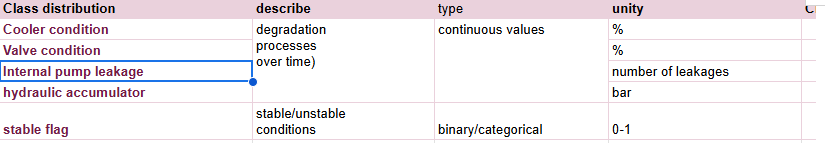

source: Dataset Overview sheet


The target "Internal Pump Leakage" has 3 classes:
> 0 : no leakage

> 1: weak leakage

> 2: severe leakage

In [ ]:
# merging features_df + target_df['internal pump leakage']
df_final = pd.concat([features_df, df_targets], axis=1)
df_final

In [ ]:
df_final.isna().sum().sum()

In [ ]:
num_duplicates = df_final.duplicated().sum()
print(f'Number of duplicated rows {num_duplicates}')

checking correlation between columns and target values before applying a dimension reduction method

In [ ]:
# Compute full correlation matrix
corr_matrix = features_df.corr()

# Mask the diagonal and lower triangle to avoid duplicates
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Apply mask and filter for strong correlations
strong_corr = corr_matrix.where(mask).stack().reset_index()
strong_corr.columns = ['Feature1', 'Feature2', 'Correlation']
strong_corr_filtered = strong_corr[strong_corr['Correlation'].abs() >= 0.8]

# Display strong correlations
print("Strong correlations (≥ 0.8 or ≤ -0.8) between features:")
print(strong_corr_filtered.sort_values(by='Correlation', ascending=False))

# Optional: Visualize them in a heatmap if not too many
if not strong_corr_filtered.empty:
    # Get unique features involved
    high_corr_features = pd.unique(strong_corr_filtered[['Feature1', 'Feature2']].values.ravel('K'))

    # Subset the correlation matrix to just those features
    high_corr_matrix = features_df[high_corr_features].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(high_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, vmin=-1, vmax=1)
    plt.title("Heatmap of Highly Correlated Features (|corr| ≥ 0.8)", fontsize=16)
    plt.show()
else:
    print("No features found with correlation ≥ 0.8 or ≤ -0.8.")


the correlation matrix heatmap wouldn't show much because there are too many columns to consider. so we'll see how many high correlation pairs there are :

In [ ]:
corr_matrix = features_df.corr().abs()
high_corr = (corr_matrix > 0.8) & (corr_matrix < 1.0)
print("Number of high-correlation pairs:", high_corr.sum().sum() // 2)


In [ ]:
# Get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Unstack and sort
sorted_pairs = upper.unstack().sort_values(ascending=False).dropna()

# Get top 30 most correlated feature pairs
top_corr = sorted_pairs[0:30]

# Plot as a bar chart
plt.figure(figsize=(12, 6))
top_corr.plot(kind='bar')
plt.title("Top 30 Most Highly Correlated Feature Pairs")
plt.ylabel("Correlation coefficient")
plt.show()


too many features are highly correlated

In [ ]:
# Step 1: Select numeric columns and compute correlations with the target
target = 'cooler_condition'
correlations = df_final.corr()[target]

# Step 2: Filter only high correlations (above threshold)
threshold = 0.95
high_corr = correlations[correlations.abs() >= threshold]
high_corr = high_corr.drop(target)  # Drop self-correlation

# Step 3: Create a heatmap (or barplot)
plt.figure(figsize=(10, len(high_corr) * 0.4))  # Dynamic height based on number of features
sns.heatmap(high_corr.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title(f"Features highly correlated with {target}", fontsize=16)
plt.show()


NB: the target cooler_condition has too many features highly correlated with it.. we might need to treat it individually later

High correlation across multiple features leads to multicollinearity, which can make interpretation challenging and introduce redundancy in training. While tree-based models handle this better, minimizing unnecessary correlations improves efficiency and clarity.
In this case we should use PCA, as it transforms correlated features into a smaller set of orthogonal components, preserving essential variance while reducing complexity. This ensures a more streamlined, interpretable approach to feature representation.


in order to apply PCA we first need to
1. Standarize the features

In [ ]:
X = features_df

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Applying PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95) #choose number of components that explain 95% of the variance
X_pca  = pca.fit_transform(X_scaled)

In [ ]:
print(f"Original features: {X.shape[1]}")
print(f"Reduced PCA components: {X_pca.shape[1]}")


We went from 202 columns to 19 columns using PCA
this will improve many factors :
- make the model simpler later
- faster training
- lower risk of overfitting
- clean interpretability



♦ A figure explaining how the pca works :

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Variance Explained")
plt.grid()
plt.show()


In [ ]:
X_df = pd.DataFrame(X_pca)
X_df

In [ ]:
# DF with pca features and target values
df = pd.concat([X_df, df_targets], axis = 1)
df

# 3. EDA
## 1. Correlation matrices
we're working with X_df : contains features
y contains target value

In [ ]:
import seaborn as sns
correlation_matrix = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot = True, cmap ="coolwarm", fmt ='.2f', linewidth =.5)
plt.title("correlation heatmap of df", fontsize =18)
plt.show()

In [ ]:
df.columns

The column 0 is leaking the target cooler_condition
therefore we should drop it

In [ ]:
df = df.drop(columns=[0])

In [ ]:
df.describe().T

In [ ]:
from ydata_profiling import ProfileReport

profile  = ProfileReport(df, title = 'Data Profiling Report')
profile

In [ ]:
plt.style.use("seaborn-v0_8-white")
axes = df.hist(bins = 20, figsize =(20,10), color="lightblue" , edgecolor ="blue")

for ax in axes.ravel():
    ax.set_title(ax.get_title(), fontsize = 20)
plt.show()

The dataset seems normal distributed but to be sure we'll run other tests

---

1. Boxplot : To identify skewness and outliers

In [ ]:
for column in df.columns:
  sns.boxplot(x = df[column])
  plt.title(column)
  plt.show()

In [ ]:
#Calculate the IQR for each column
for column in df.columns :
  iqr_values = df.quantile(.75) - df.quantile(.25)
  print(f"{column} : {iqr_values[column]:.2f}")

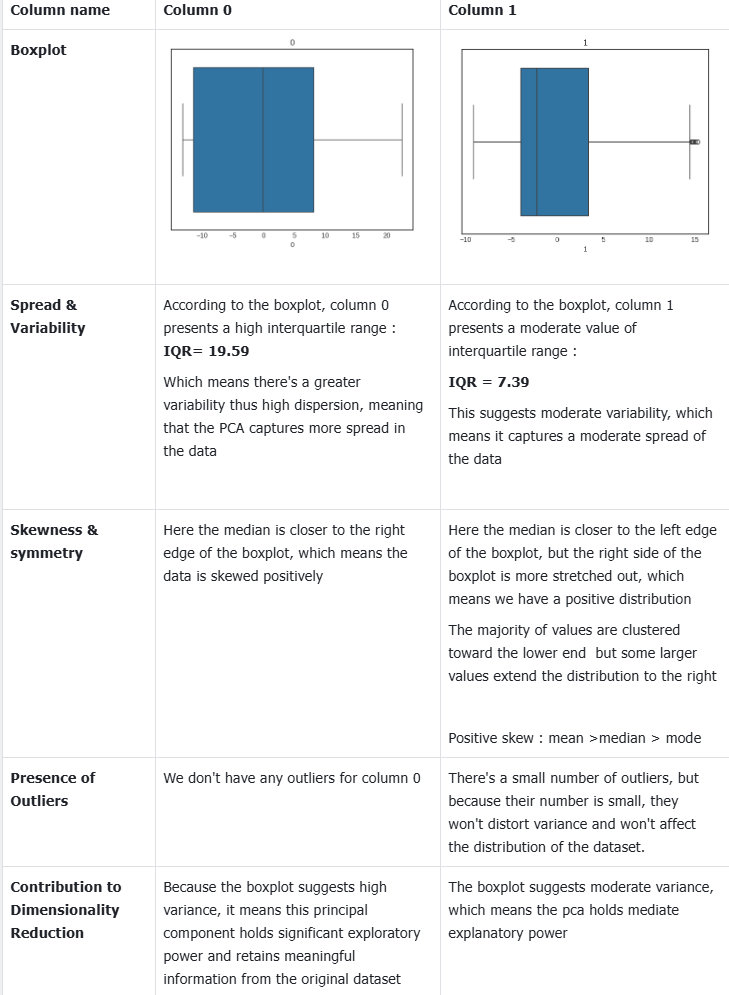

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
# visualize target variables to see if the dataset is balanced y

# Loop through each column in df_targets
for column in df_targets.columns:
    class_counts = df_targets[column].value_counts()

    # Create a new figure for each plot
    plt.figure(figsize=(6, 4))

    class_counts.plot(kind="bar", color=["blue", "orange", "green"])
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title(f"Class Distribution for {column}")

    # Show plot
    plt.show()

the dataset is highly imbalanced, therefore we'll use  stratified cross-validation

# 4. Machine Learning Model

In this part we will start by working a simple machine learning model to train the data on, and see the result, we will then use XGboost to compare the results between the 2 models.


The simple ML model chosen is Logistic Regression, and because for the target 'internal_pump_leakage" we only have three classes we'll be working with the multi_class classification: One_vs_Rest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

- **X_df** : features

- **df_targets** : targets
---------------

- **df** : X_df + df_targets
- **y** : we have 4 target values, we'll start by working with one *y = df['internal_pump_leakage']*

#### * Working on the first target :'internal_pump_leakage'

In [ ]:
y = df['internal_pump_leakage']

In [ ]:
# split data into train 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y , test_size = 0.2, stratify=y , random_state = 42)

In [ ]:
LR = LogisticRegression(max_iter = 1000, multi_class = 'ovr')
LR.fit(X_train, y_train)

In [ ]:
y_pred_LR = LR.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print(f"Accuracy from the LR model is {accuracy_LR :.4f}")
print(classification_report(y_test,y_pred_LR))

We'll take the results of the logistic regression as reference for the more complex ML model XGBoost:

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
#initialize XGBoost model
xgb_model =xgb.XGBClassifier(use_label_encoder = False, eval_metric = "mlogloss")

#train the model
xgb_model.fit(X_train, y_train)

#Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy from the XGBoost model is {accuracy_xgb :.4f}")
print(classification_report(y_test, y_pred_xgb))


The XGBoost model presented better accuracy result so we'll be using it for this study.
We'll be improving the XGBoost model with hyperparameter tuning
### 1. Hyperparameter tuning with GridSearchCV

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold , GridSearchCV

In [ ]:
skf = StratifiedKFold (n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_grid = {
    "max_depth" : [3, 5, 7], #tree depth
    "learning_rate" : [.01 , .1], # step size for weight updates
    "n_estimators": [100, 300, 500], #number of boosting rounds
    "subsample" : [.6, .8, 1.0], #fraction of samples per tree
    "colsample_bytree" : [.6,.8, 1.0] #fraction of features per tree


}

In [ ]:
grid_search = GridSearchCV (
    estimator = xgb.XGBClassifier(use_label_encoder = False, eval_metric ='mlogloss'),
    param_grid = param_grid,
    cv = skf,
    scoring = 'f1_weighted',
    verbose = 1,
    n_jobs = -1



)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

### 2. Model Evaluation
#### a. F1-score

Definitions:
- **F1_weighted** : takes class imbalance into account by weighing the contribution of each class based on its support (count of each class), in other terms in ensures that ckasses with more samples have a bigger impact on the final score.

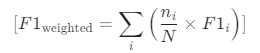


- **F1_macro**: to test fairness: averages F1-scores across classes without considering support - treats all classes equally


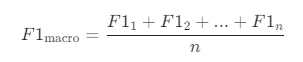

So basically:

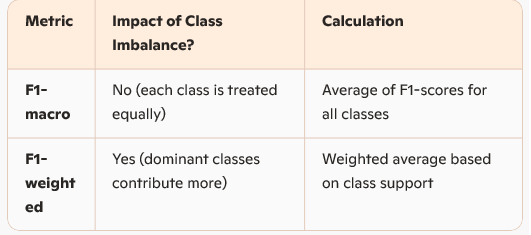

In [ ]:
from sklearn.metrics import classification_report, f1_score

#Best model from grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#classificaiotion report
print(classification_report(y_test, y_pred))



f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Weighted F1 Score:", f1_weighted)
print("Macro F1 Score:", f1_macro)

When dealing with imbalanced multiclass classification, relying solely on accuracy can be misleading. Instead, F1-weighted and F1-macro provide a clearer picture of model performance by balancing precision and recall across all classes.
The model is performing well, showing strong generalization while maintaining fairness across different categories. Thanks to GridSearchCV, we fine-tuned hyperparameters to enhance stability and ensure the model remains effective across the dataset.


#### b. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

#plot the confision matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)
fig, ax = plt.subplots(figsize = (6,6))
disp.plot(ax=ax , cmap ='Blues', values_format = 'd')
plt.title('confusion matrix')
plt.grid(False)
plt.show()

from the confusion matrix we can see that the model predicts the y_test value really well, for the three classes and it's fair across all classes

# 5. Pipeline
Because we have 5 targets we'll create a pipeline to automate the training , testing and tuning of the model for each target.

## 1. Define the target variable names

In [ ]:
target_names = [

    "valve_condition",
    "internal_pump_leakage",
    "accumulator_pressure",
    "stable_flag",
    "cooler_condition"

]
target_names

In [ ]:
df_targets

###  Unique values of the target values

In [ ]:
# unique values of the target values
for column in df_targets.columns:
  print(f"unique values of {column} are {df_targets[column].unique()}")

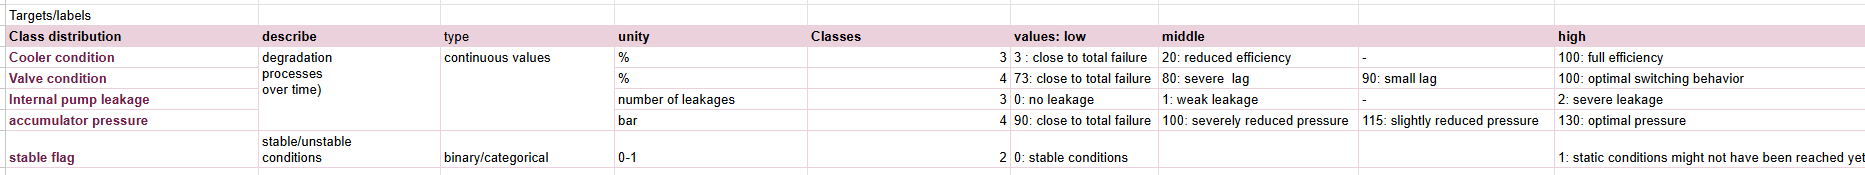

###  Encode the target values because XGClassifier expects class labels but the targets are numerical

In [ ]:
df['cooler_condition'] = df['cooler_condition'].replace({3: 0, 20: 1, 100: 2 })
df['valve_condition'] = df['valve_condition'].replace({73: 0, 80: 1, 90: 2 , 100:3 })
df['accumulator_pressure'] = df['accumulator_pressure'].replace({90: 0, 100: 1, 115: 2, 130:3 })

print("df: ")
display (df)


df_targets['cooler_condition'] = df_targets['cooler_condition'].replace({3: 0, 20: 1, 100: 2})
df_targets['valve_condition'] = df_targets['valve_condition'].replace({73: 0, 80: 1, 90: 2, 100: 3})
df_targets['accumulator_pressure'] = df_targets['accumulator_pressure'].replace({90: 0, 100: 1, 115: 2, 130: 3})

print("df targets")
display(df_targets)

In [ ]:
for target in target_names:
    print(f"\n === Training model for target : {target}")
    #define the target
    y = df[target]

    #split the data
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = .2, random_state=42, stratify = y)

    #train model
    xgb_model = XGBClassifier(use_label_encoder = False, eval_metric ="mlogloss")
    xgb_model.fit(X_train, y_train)

    #predict y_pred
    y_pred = xgb_model.predict(X_test)

    #classififcaiton report
    print(classification_report(y_test, y_pred))

    #F1 scores
    f1_weighted = f1_score(y_test, y_pred, average = "weighted")
    f1_macro = f1_score(y_test, y_pred, average = "macro")
    print(f"weighted F1 score {f1_weighted:.4f}")
    print(f"macro f1-score : {f1_macro:.4f}")

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = xgb_model.classes_)
    disp.plot(cmap = "Blues")
    plt.title(f"consion matrix for {target}")
    plt.show()

The target cooler_condition had an accuracy of 100% other targets like accumulator_pressure have a low accuracy : 78% so each target should be treated individually and the model and the hyperparameter tuning should be done for each target individually.

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

DataFrames i'll be using:

- features_df : original statistical features
- df_targets : df of targets
- df_final =  statistical features  + targets

- X_df : df with pca features and no targets
- df : X_df + df_targets_encoded

In [ ]:
"""features_df.to_csv('/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/features_df.csv', index=False)
df_targets.to_csv('/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/df_targets.csv', index=False)
df_final.to_csv('/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/df_final.csv', index=False)
X_df.to_csv('/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/X_df.csv', index=False)
df.to_csv('/content/drive/MyDrive/bootcamp GMC data science/Projects/final project/final project/df.csv', index=False)"""

In [ ]:
import joblib

# Save the model
joblib.dump(xgb_model, "xgb_internal_pump_leakage.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save the PCA transformer
joblib.dump(pca, "pca.pkl")


In [ ]:
from google.colab import files
files.download("xgb_internal_pump_leakage.pkl")
files.download("scaler.pkl")
files.download("pca.pkl")

In [ ]:
import joblib as jbl
jbl.dump(features_df.columns.tolist(), "original_columns.pkl")

In [ ]:
jbl.dump(features_df.iloc[0].tolist(), "default_input.pkl")

In [ ]:
files.download("original_columns.pkl")
files.download("default_input.pkl")

Because we work with 202 it's not practical for deployment and testing therefore we'll create another dataset using only the mean features

In [ ]:
mean_feature_cols = [col for col in features_df.columns if col.endswith("_mean")]
X_means = features_df[mean_feature_cols]

In [ ]:
y = df["internal_pump_leakage"]


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_means, y, test_size=0.2, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train_scaled, y_train)

# Save
jbl.dump(model, "xgb_means_model.pkl")
jbl.dump(scaler, "means_scaler.pkl")
jbl.dump(X_means.columns.tolist(), "mean_columns.pkl")
jbl.dump(X_means.iloc[0].tolist(), "default_input_mean.pkl")  # optional: use as a default form input


In [ ]:
files.download("xgb_means_model.pkl")
files.download("means_scaler.pkl")
files.download("mean_columns.pkl")
files.download("default_input_mean.pkl")

In [ ]:
print("displaying X_means")
display(X_means)
print("displaying y target")
display(y)

In [ ]:
y.unique()

In [ ]:
# Step 1: Add target to the means dataframe
X_means_with_target = X_means.copy()
X_means_with_target["internal_pump_leakage"] = df["internal_pump_leakage"]

# Step 2: Compute correlation matrix
corr_matrix = X_means_with_target.corr()

# Step 3: Extract correlation with the target only
corr_with_target = corr_matrix["internal_pump_leakage"].drop("internal_pump_leakage")

# Step 4: Print sorted correlation values
print(corr_with_target.sort_values(ascending=False))

# Step 5: Optional – Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation between Mean Features and Internal Pump Leakage")
plt.show()


In [ ]:
# seeing which rows present strong leakage : y ==2
filtered_rows_2 = y[y == 2]
display(filtered_rows_2)
#seing the values for testing in streamlit
display(X_means.iloc[210])